# Competition

The score in this homework is counted as extra credits.

Anyone who complete the competition will be ranked. The higher ranking you get, the more extra credits you will recieve. The minimum amount of extra credits is 1 point, and the maximum is 2 points.

**The winner will also recieve a physical grand prize from your dearest boss, Hamtaro!**

Hamtaro wants to tweak his e-commerce website for his one-time Super HamHam Father's day Grand Sale Extravaganza which starts on 5/12/23. He has 6 possible tweaks.

*   Tweak 1: Display price in THB or Hamtaro coins
*   Tweak 2: Buy button at the bottom or at the top of the page
*   Tweak 3: Checkout process requires sign in or not
*   Tweak 4: Checkout process has orange button or grey button
*   Tweak 5: Checkout process has music or not
*   Tweak 6: Checkout process has final confirmation or not

Figure out which combination of tweaks should be used via multi-arm bandit.

In other words, choose the best combination of six binary settings that will optimize the conversion.

In [98]:
import requests
import json

url = 'http://183.90.168.139:5001/'

# Instruction

There is a 6-arm bandit (many arms can be toggled at once). The bandit will return only one binary reward for each pull, which is zero or one.
In other words, the returning reward depends on the arms being pulled and there are $2^6$ combinations in total.

You will receive an account that can pulls **1000** times.
Your goal is to maximize the cumulative reward of the **last 950 pulls**. In order to be eligible for the competition you must pull at least 50 times.

#Pull arm

Send a **POST** request to http://183.90.168.139:5001/update_state. \
You have to pass 2 attributes in the request json


*   times: number of pulls (positive interger). If `times` > 1, the same pulling policy, which is defined in `arms`, will be used. This variable is designed to reduce the number requests.
*   arms: list of arms that you want to configure (maximum length = 6, number of arm between = [1,6])


You can get the token from mycourseville. Go to the CEM2 course page and look at your portfollio. **Your authorization token is the concatenation of two scores, `<token1><token2>`**. Each token is a five digit number.

**!! Don't forget to pass your token as string in headers of request !!**

In [66]:
your_token = '4160541337'

In [138]:
import requests
import json

# In this example call, you are showing 10 customers
#    with tweaks 1, 2, 3, 4, and 5 as yes
#    and tweak 6 is no.
def update_state(times, arms):
	r = requests.post(f'{url}/update_state',
                  json={"times":times, "arms":arms},
                  headers= {"Authorization": your_token})
	print(r.content)
	return json.loads(r.content)

In [ ]:
update_state()

{'limit_reach': False,
 'request_reward': [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'status': 200}

**Response** \
You will receive JSON object in response content. \
\
In JSON,

*   limit_reach: True if your account reach 1000 times of pulling, False otherwise.
*   request_reward: list of reward according to your request. The $i^{th}$ element indicates the reward of $i^{th}$ pull. The size of this list is equal to the variable `times`.


#Get the state of your account

In case that you forget to memorize the historical rewards, you can use our API to access to all of the rewards you have made.

Send **GET** request to http://183.90.168.139:5001/get_state. \

**!! Don't forget to pass your token as string in headers of request !!**

In [100]:
def get_state():
	r = requests.get(f'{url}/get_state',
                  headers= {"Authorization": your_token})
	print(r.content)
	return json.loads(r.content)

In [119]:
result = get_state()

print(type(result['state']['reward_list']))

b'{"state":{"count":0,"cumulative_reward":0,"reward_list":[]},"status":200}\n'
<class 'list'>


**Response** \
You will receive JSON object in response content. \
\
In JSON, your account state is inside state attribute

*   count: number of pulls that you already used.
*   cumulative_reward: summation of received reward from the first request upto the last one.
*   reward_list: full history of received reward. The $i^{th}$ element indicates the reward of $i^{th}$ pull. This is an extend version of `request_reward` you received from using update API.

# Beware of the limit
After you reach the number of allowed requests, the API will not return any additional rewards.

However, you can still get your **whole** historialcal rewards from `get_state` API.

Your token can pull the bandit's arm for exactly `1000` times.

In [ ]:
r = requests.get(f'{url}/get_state',
                  headers= {"Authorization": your_token})

In [ ]:
json.loads(r.content)

{'state': {'count': 30,
  'cumulative_reward': 8,
  'reward_list': [0,
   1,
   0,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   0,
   1,
   0,
   0,
   0,
   1]},
 'status': 200}

# Solution

In [2]:
%pip install qtable


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Softmax

import math
import random

class Softmax():
    def __init__(self, tau=1.0):
        self.tau = tau

    def reset(self):
        pass

    def select(self, state, actions, qfunction):

        # calculate the denominator for the softmax strategy
        total = 0.0
        for action in actions:
            total += math.exp(qfunction.get_q_value(state, action) / self.tau)

        rand = random.random()
        cumulative_probability = 0.0
        result = None
        for action in actions:
            probability = (
                math.exp(qfunction.get_q_value(state, action) / self.tau) / total
            )
            if cumulative_probability <= rand <= cumulative_probability + probability:
                result = action
            cumulative_probability += probability

        return result

In [12]:
# UCB

import math
import random

class UpperConfidenceBounds():
    def __init__(self):
        self.total = 0
        # number of times each action has been chosen
        self.times_selected = {}
        
    def reset(self):
        self.__init__()

    def select(self, state, actions, qfunction):

        # First execute each action one time
        for action in actions:
            if action not in self.times_selected.keys():
                self.times_selected[action] = 1
                self.total += 1
                return action

        max_actions = []
        max_value = float("-inf")
        for action in actions:
            value = qfunction.get_q_value(state, action) + math.sqrt(
                (2 * math.log(self.total)) / self.times_selected[action]
            )
            if value > max_value:
                max_actions = [action]
                max_value = value
            elif value == max_value:
                max_actions += [action]

        # if there are multiple actions with the highest value
        # choose one randomly
        result = random.choice(max_actions)
        self.times_selected[result] = self.times_selected[result] + 1
        self.total += 1
        return result

In [58]:
from collections import defaultdict
import random

class QTable:
    def __init__(self):
        self.table = defaultdict(lambda: defaultdict(lambda: 0))

    def get_q_value(self, state, action):
        return self.table[state][action]

    def update(self, state, action, value):
        self.table[state][action] += value

    def get_best_action(self, state):
        best_action = None
        best_value = float("-inf")
        for action in self.table[state]:
            if self.table[state][action] > best_value:
                best_value = self.table[state][action]
                best_action = action
        return best_action

    def get_action_values(self, state):
        return self.table[state]

    def get_state_values(self):
        state_values = {}
        for state in self.table:
            state_values[state] = self.get_best_action(state)
        return state_values

    def get_table(self):
        return self.table

    def set_table(self, table):
        self.table = table

""" Run a bandit algorithm for a number of episodes, with each episode
being a set length.
"""

def run_bandit(bandit, episodes=200, episode_length=500, drift=True):

    # The actions available 0-63
    actions = list(range(0, 64))

    # A dummy state
    state = 1

    rewards = []
    for _ in range(0, episodes):
        bandit.reset()

        # The probability of receiving a payoff of 1 for each action 0-63 (random)
        probabilities = [random.random() for _ in range(0, 64)]

        # The number of times each arm has been selected
        times_selected = defaultdict(lambda: 0)
        qtable = QTable()

        episode_rewards = []
        for step in range(0, episode_length):

            # Halfway through the episode, change the probabilities
            if drift and step == episode_length / 2:
                probabilities = [random.random() for _ in range(0, 64)]

            # Select an action using the bandit
            action = bandit.select(state, actions, qtable)

            # Get the reward for that action
            reward = 0
            if random.random() < probabilities[action]:
                reward = 5

            episode_rewards += [reward]

            times_selected[action] = times_selected[action] + 1
            qtable.update(
                state,
                action,
                (reward / times_selected[action])
                - (qtable.get_q_value(state, action) / times_selected[action]),
            )

        rewards += [episode_rewards]

    return rewards

(1, 1000)


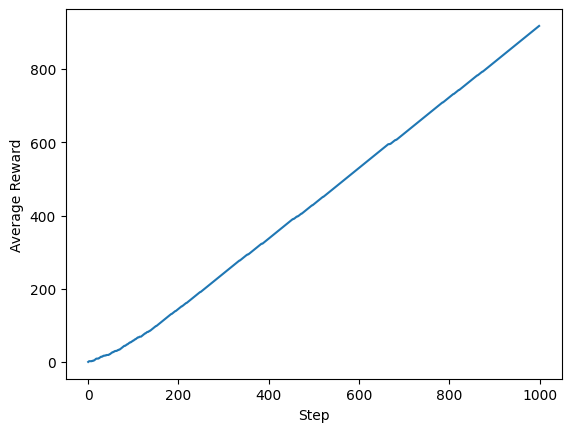

In [59]:
import matplotlib.pyplot as plt
import numpy as np

UCBbandit = UpperConfidenceBounds()

def plot_comparison(drift=False):
    ucb = run_bandit(UCBbandit, episodes=1, episode_length=1000, drift=drift)
    print(np.shape(ucb))
    
    # plot mean from begin to i
    ucb = [np.count_nonzero(np.array(ucb)[:, :i], axis=1).mean() for i in range(1, 1001)]
    plt.plot(ucb, label="UCB")
    plt.xlabel("Step")
    plt.ylabel("Average Reward")
    plt.show()




plot_comparison(drift=False)

In [160]:
actions = list(range(0, 64))

In [147]:
bandit = UpperConfidenceBounds()
actions = list(range(1, 64))
rewards = []

# The number of times each arm has been selected
times_selected = defaultdict(lambda: 0)
qtable = QTable()

log = []

In [148]:
# turn action into bit number (ex. 12 => 001100) means select 3rd and 4th arm
# result is [3, 4]

def get_selecting_arms(action):
    selecting_arms = [int(x) for x in list('{0:0b}'.format(action))]
    selecting_arms = [0] * (6 - len(selecting_arms)) + selecting_arms
    selecting_arms = selecting_arms[::-1]
    selecting_arms = [i+1 for i, x in enumerate(selecting_arms) if x == 1]
    return selecting_arms

def work(episode_length):

    # A dummy state
    state = 1

    episode_rewards = []
    for step in range(0, episode_length):

        # Select an action using the bandit
        action = bandit.select(state, actions, qtable)

        # turn action into bit number (ex. 2 => 0010) means select 2nd arm
        selecting_arms = get_selecting_arms(action)

        # Get the reward for that action
        reward = update_state(1, selecting_arms)['request_reward'][0]

        log.append({'action': action, 'reward': reward})

        episode_rewards += [reward]

        times_selected[action] = times_selected[action] + 1
        qtable.update(
            state,
            action,
            (reward / times_selected[action])
            - (qtable.get_q_value(state, action) / times_selected[action]),
        )
    global rewards
    rewards += [episode_rewards]

    return rewards

In [159]:
get_selecting_arms(0)

[]

{1: 1, 2: 1}

In [197]:
print(work(1))
print()
# print(log)

b'{"limit_reach":true,"request_reward":[],"status":402}\n'


IndexError: list index out of range

In [195]:
# print log each line
for i in range(len(log)):
	print(f'{i+1}th action: {log[i]["action"]}, reward: {log[i]["reward"]}')

1th action: 1, reward: 0
2th action: 2, reward: 1
3th action: 3, reward: 0
4th action: 4, reward: 0
5th action: 5, reward: 0
6th action: 6, reward: 1
7th action: 7, reward: 0
8th action: 8, reward: 0
9th action: 9, reward: 0
10th action: 10, reward: 0
11th action: 11, reward: 0
12th action: 12, reward: 0
13th action: 13, reward: 0
14th action: 14, reward: 0
15th action: 15, reward: 1
16th action: 16, reward: 0
17th action: 17, reward: 0
18th action: 18, reward: 0
19th action: 19, reward: 0
20th action: 20, reward: 0
21th action: 21, reward: 0
22th action: 22, reward: 0
23th action: 23, reward: 0
24th action: 24, reward: 0
25th action: 25, reward: 0
26th action: 26, reward: 0
27th action: 27, reward: 1
28th action: 28, reward: 0
29th action: 29, reward: 0
30th action: 30, reward: 1
31th action: 31, reward: 0
32th action: 32, reward: 1
33th action: 33, reward: 1
34th action: 34, reward: 0
35th action: 35, reward: 0
36th action: 36, reward: 0
37th action: 37, reward: 1
38th action: 38, re

In [196]:
get_state()

b'{"state":{"count":1000,"cumulative_reward":288,"reward_list":[0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,1,1,1,1,0,0,1,1,1,0,0,0,1,0,1,1,0,0,1,1,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,1,0,1,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,

{'state': {'count': 1000,
  'cumulative_reward': 288,
  'reward_list': [0,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   1,
   0,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   0,
   1,
   1,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   1,
   0,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
 

In [157]:
# after 50 times

get_state()

b'{"state":{"count":50,"cumulative_reward":12,"reward_list":[0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0]},"status":200}\n'


{'state': {'count': 50,
  'cumulative_reward': 12,
  'reward_list': [0,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   1,
   0,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   1,
   0]},
 'status': 200}